In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)

In [2]:
pd.set_option('display.float_format', '{:.2%}'.format)

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA']
start_date = '2024-01-01'
end_date = '2025-04-24'

data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close'][tickers]
rt = data.pct_change().dropna()

mu = rt.mean() * 252
sigma = rt.std() * np.sqrt(252)

metricas = pd.DataFrame({
    'Rendimiento': mu,
    'Volatilidad': sigma,
})
metricas.T

YF.download() has changed argument auto_adjust default to True


Ticker,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA
Rendimiento,12.49%,4.21%,14.10%,19.45%,23.93%,75.47%
Volatilidad,30.33%,23.51%,30.74%,32.03%,68.95%,58.53%


In [3]:
pd.reset_option('display.float_format')
prices_df = pd.DataFrame({
    'Precio Final': data.iloc[-1],
})
prices_df.T

Ticker,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA
Precio Final,204.600006,374.390015,155.350006,180.600006,250.740005,102.709999


In [4]:
strikes = [205, 385, 160, 185, 255, 105]

In [5]:
class OptionPayoff:
    def __init__(self) -> None:
        pass

    @staticmethod
    def long_call_payoff(st, k, premium):
        return np.maximum(st - k, 0) - premium
    
    @staticmethod
    def short_call_payoff(st, k, premium):
        return premium - np.maximum(st - k, 0)
    
    @staticmethod
    def long_put_payoff(st, k, premium):
        return np.maximum(k - st, 0) - premium
    
    @staticmethod
    def short_put_payoff(st, k, premium):
        return premium - np.maximum(k - st, 0)

In [6]:
class MultiStraddle:
    def __init__(self, tickers, start_date, end_date, strikes, n_sims=100_000):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.strikes = strikes
        self.n_sims = n_sims
        self.option = OptionPayoff()

        self.data = yf.download(self.tickers, self.start_date, self.end_date, progress=False)['Close'][self.tickers]
        self.rt = self.data.pct_change().dropna()
        self.mu = self.rt.mean().values
        self.sigma = self.rt.std().values
        self.anual_sigma = self.sigma * np.sqrt(252)
        self.last_price = self.data.iloc[-1].values

    def simulate_price(self, mu, sigma, last_price):
        Z = np.random.normal(size=(self.n_sims, 252))
        returns = mu + sigma * Z
        cumulative_returns = (returns + 1).cumprod(axis=1)
        return last_price * cumulative_returns
    
    def black_scholes_price(self, So, K, T, rf, sigma, option_type='call'):
        d1 = (np.log(So / K) + (rf + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            price = (So * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-rf * T) * norm.cdf(d2, 0.0, 1.0))
        else:
            price = (K * np.exp(-rf * T) * norm.cdf(-d2, 0.0, 1.0) - So * norm.cdf(-d1, 0.0, 1.0))
        return price

    def american_option_price(self, So, K, T, rf, sigma, n, option_type='call'):
        dt = T / n
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        disc = np.exp(-rf * dt)
        p = (np.exp(rf * dt) - d) / (u - d)
        j = np.arange(n + 1)
        ST = So * (u ** (n - j)) * (d ** j)

        option_values = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)

        for i in range(n - 1, -1, -1):
            ST = ST[:-1] / u
            option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])
            exercise = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)
            option_values = np.maximum(option_values, exercise)

        return option_values[0]

    def straddle_payoff(self, st, k, premium_call, premium_put):
        return np.maximum(st - k, 0) - premium_call + np.maximum(k - st, 0) - premium_put

    def plot_simulations(self, prices, ticker):
        plt.figure(figsize=(8, 4))
        plt.plot(prices[:5000, :].T)
        plt.title(f'Simulated Price Paths for {ticker}')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.show()

    def plot_payoffs(self, st, long_calls, long_puts, strat_payoff, ticker):
        plt.figure(figsize=(10, 6))
        plt.plot(st, long_calls, label='Long Call Payoff', linestyle='--', color='indianred', alpha=0.5)
        plt.plot(st, long_puts, label='Long Put Payoff', linestyle='--', color='navy', alpha=0.5)
        plt.plot(st, strat_payoff, label='Strategy Payoff', color='black')
        plt.title(f'Payoff Diagrams {ticker}')
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.legend()
        plt.grid()
        plt.show()

    def execute(self, periods=[20, 62, 125, 251], times=[1/12, 1/4, 1/2, 1]):
        rows = 10_000
        st = np.linspace(0, 800, rows)

        for i in range(len(self.tickers)):
            ticker = self.tickers[i]
            prices = self.simulate_price(self.mu[i], self.sigma[i], self.last_price[i])
            display(HTML(f"<span style='font-size:20px'>{ticker}</span>"))
            self.plot_simulations(prices, ticker)

            for p, t in zip(periods, times):
                k = self.strikes[i]
                premium_call = self.black_scholes_price(self.last_price[i], k, t, 0.04, self.anual_sigma[i], 'call')
                premium_put = self.black_scholes_price(self.last_price[i], k, t, 0.04, self.anual_sigma[i], 'put')

                long_call = self.option.long_call_payoff(st[:, None], k, premium_call)
                long_put = self.option.long_put_payoff(st[:, None], k, premium_put)
                strat_payoff = self.straddle_payoff(st[:, None], k, premium_call, premium_put)

                self.plot_payoffs(st, long_call, long_put, strat_payoff, ticker)

                final_prices = prices[:, p]
                profits = self.straddle_payoff(final_prices, k, premium_call, premium_put)
                expected_profit = np.mean(profits)
                cost = premium_call + premium_put
                pct_profit = expected_profit / cost
                conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]
                win_rate = np.mean(profits > 0)

                print(f'Las ganancias esperadas ejerciendo las opciones a los {p+1} días son:')
                print(f'El profit esperado es de ${expected_profit:.2f}')
                print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
                print(f'La probabilidad de ganancia es de {win_rate:.2%}')
                print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')
                print()

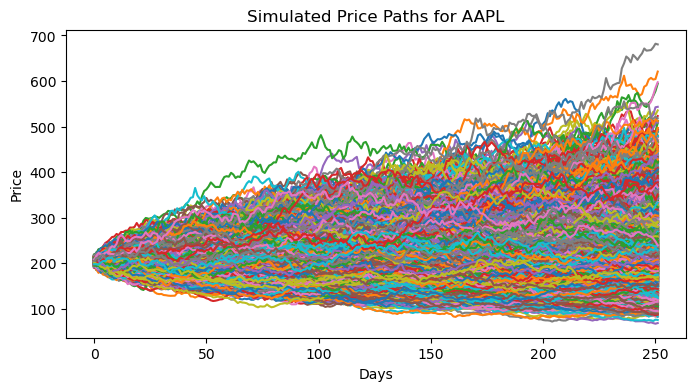

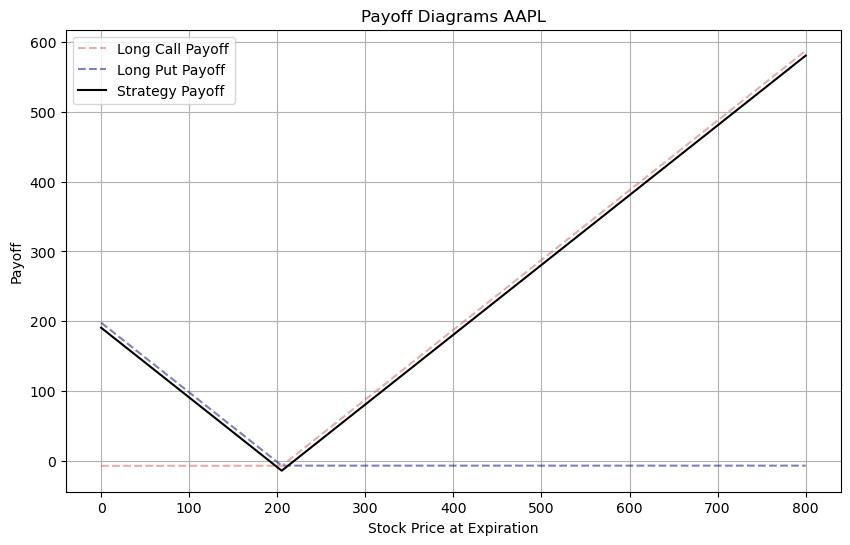

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.16
El rendimiento esperado de la estrategia es de 1.10%
La probabilidad de ganancia es de 42.80%
El intervalo de confianza del 95% para el profit es de [-13.708662214618275, 26.66367232968011]



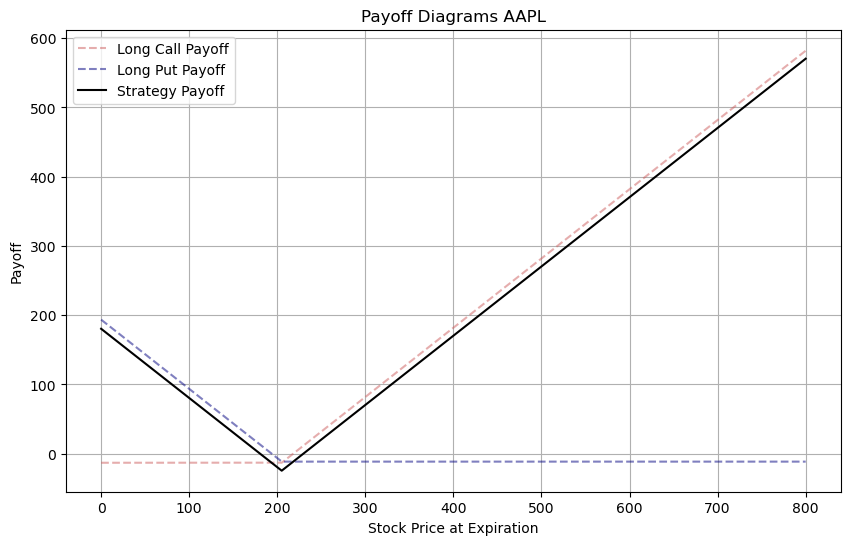

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $0.95
El rendimiento esperado de la estrategia es de 3.87%
La probabilidad de ganancia es de 43.07%
El intervalo de confianza del 95% para el profit es de [-23.68863838541978, 51.30956695084738]



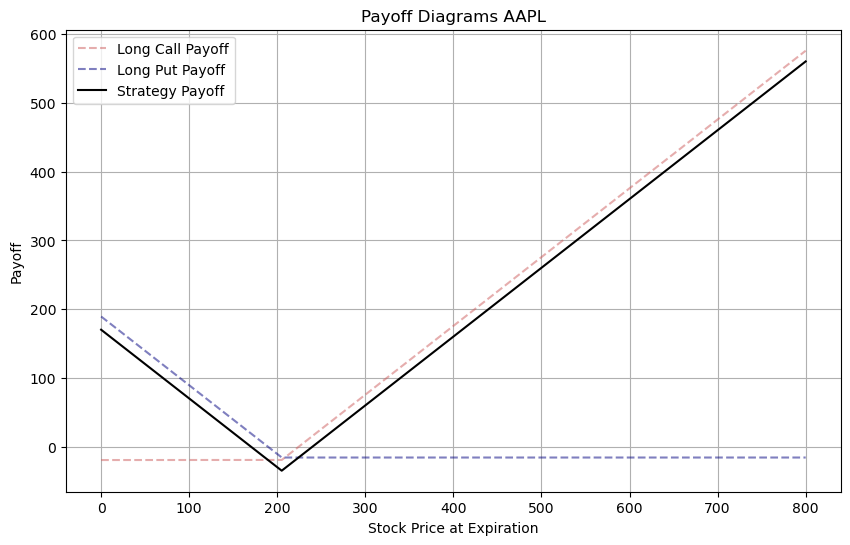

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $2.73
El rendimiento esperado de la estrategia es de 7.85%
La probabilidad de ganancia es de 43.89%
El intervalo de confianza del 95% para el profit es de [-33.34600571268227, 83.99353026601125]



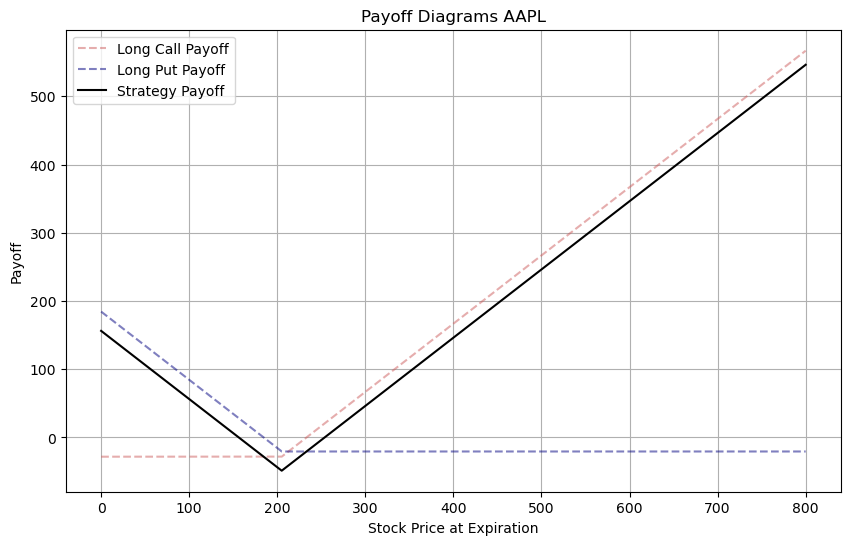

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $7.85
El rendimiento esperado de la estrategia es de 16.09%
La probabilidad de ganancia es de 45.03%
El intervalo de confianza del 95% para el profit es de [-46.72625431561788, 145.6965347932459]



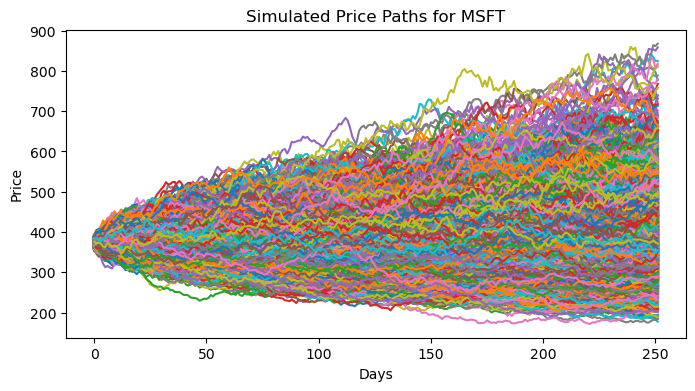

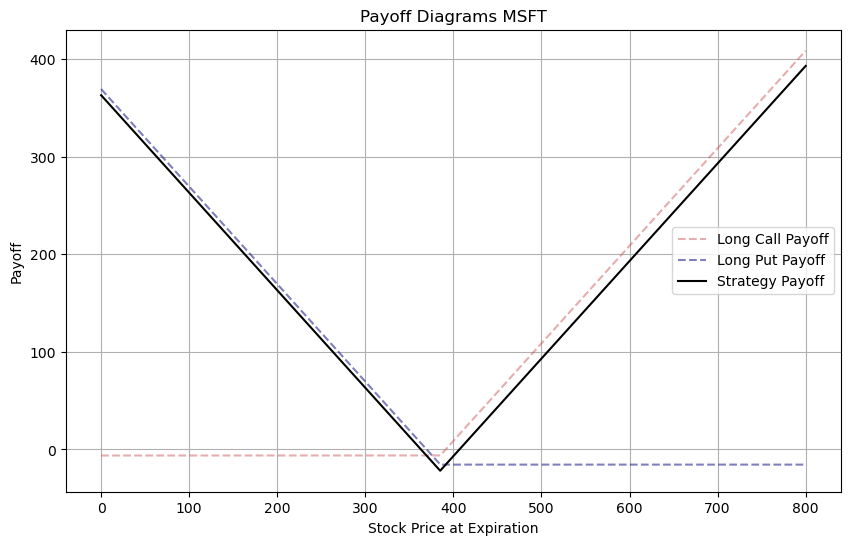

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.10
El rendimiento esperado de la estrategia es de 0.47%
La probabilidad de ganancia es de 43.44%
El intervalo de confianza del 95% para el profit es de [-20.98216786877048, 37.970914964054394]



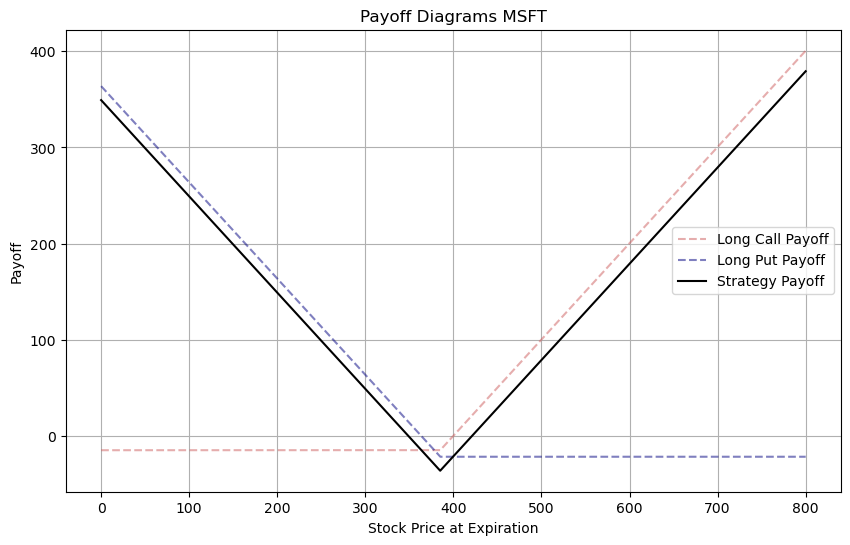

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $0.46
El rendimiento esperado de la estrategia es de 1.27%
La probabilidad de ganancia es de 43.40%
El intervalo de confianza del 95% para el profit es de [-34.35761142432467, 63.92592823226279]



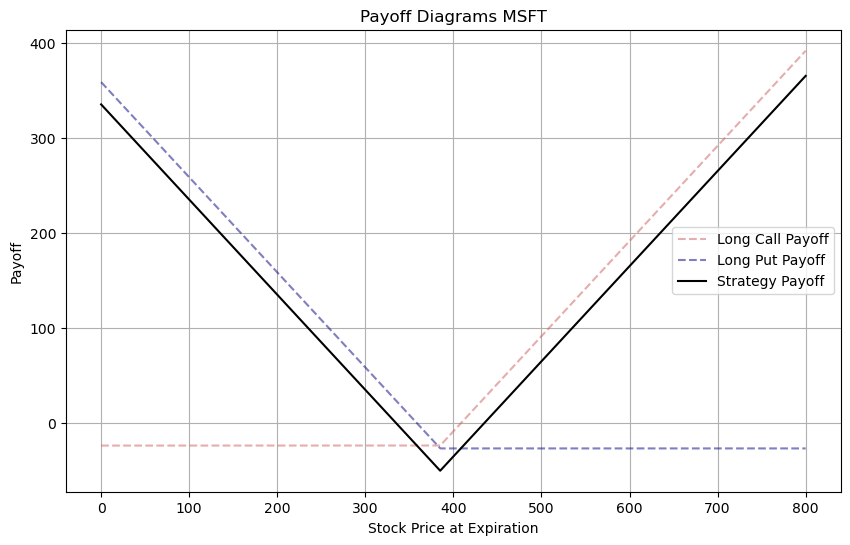

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $1.16
El rendimiento esperado de la estrategia es de 2.32%
La probabilidad de ganancia es de 43.61%
El intervalo de confianza del 95% para el profit es de [-47.86623204081927, 92.8744232895687]



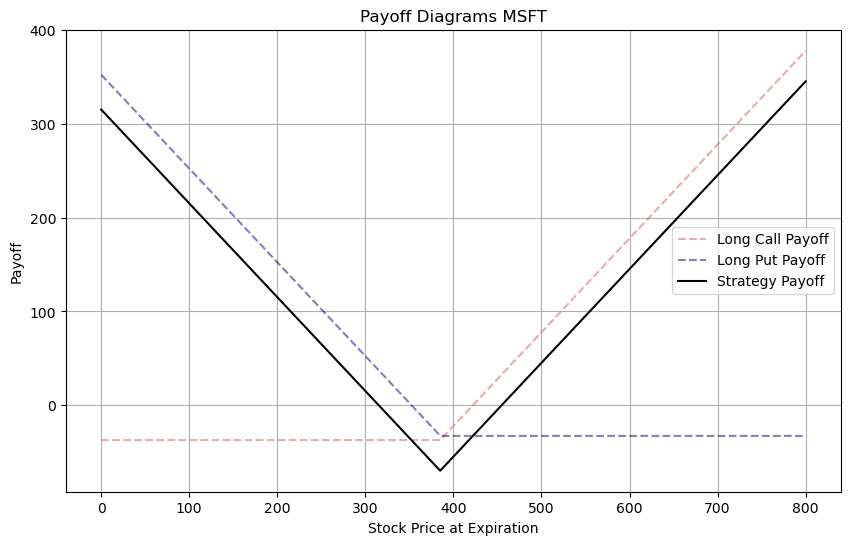

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $2.84
El rendimiento esperado de la estrategia es de 4.08%
La probabilidad de ganancia es de 43.62%
El intervalo de confianza del 95% para el profit es de [-66.909959160053, 146.62297713005512]



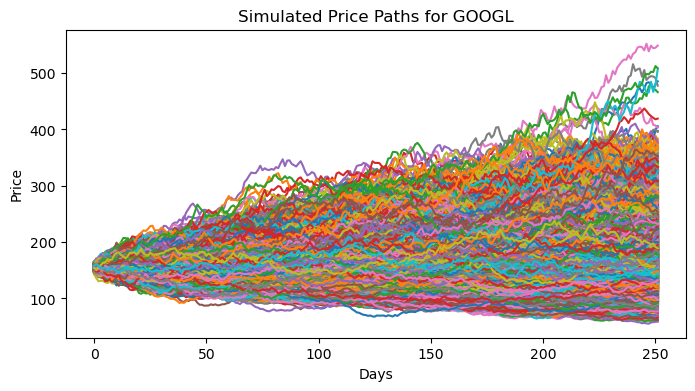

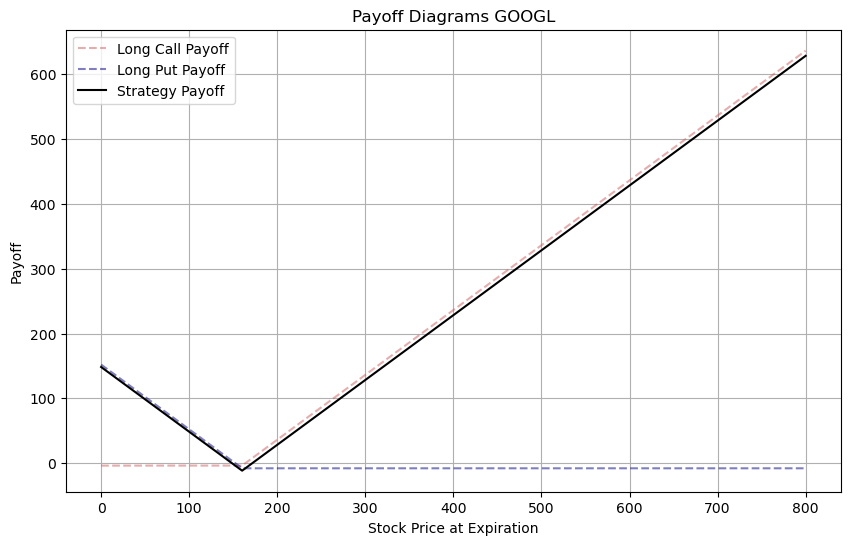

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-0.16
El rendimiento esperado de la estrategia es de -1.34%
La probabilidad de ganancia es de 42.28%
El intervalo de confianza del 95% para el profit es de [-11.146444624534164, 19.900737888850607]



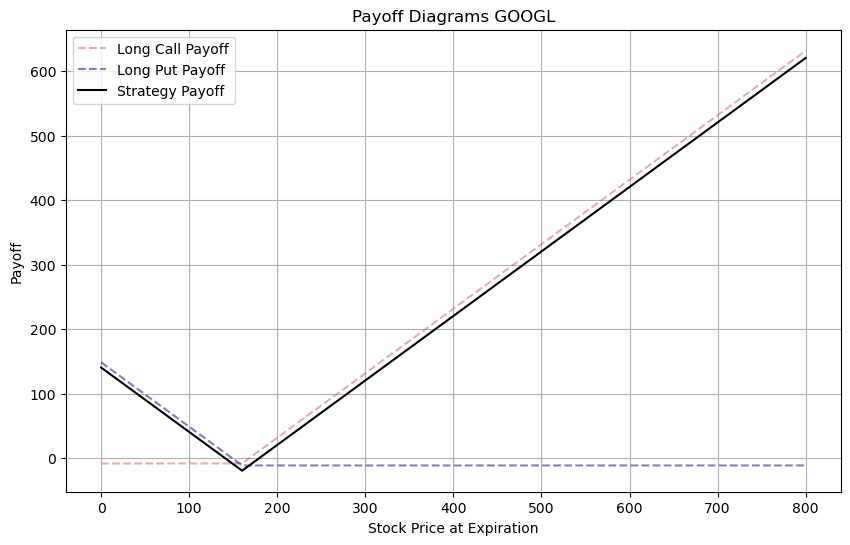

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $0.35
El rendimiento esperado de la estrategia es de 1.81%
La probabilidad de ganancia es de 43.12%
El intervalo de confianza del 95% para el profit es de [-18.57769222021984, 36.73967630264963]



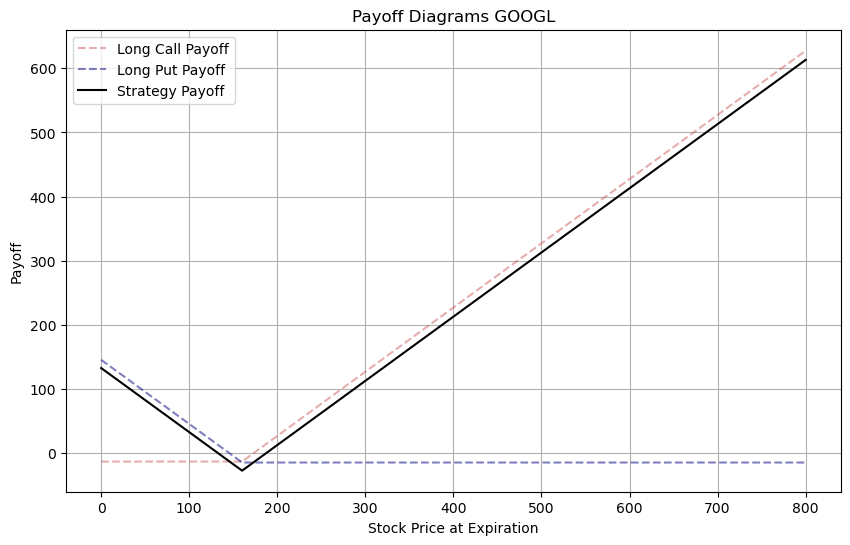

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $1.62
El rendimiento esperado de la estrategia es de 5.98%
La probabilidad de ganancia es de 43.70%
El intervalo de confianza del 95% para el profit es de [-25.98921893769782, 61.70634550266024]



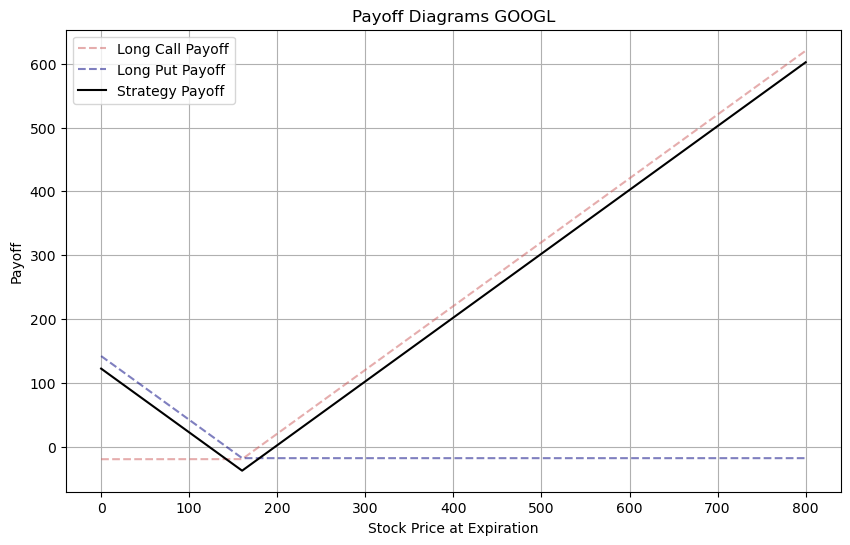

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $5.97
El rendimiento esperado de la estrategia es de 15.81%
La probabilidad de ganancia es de 45.34%
El intervalo de confianza del 95% para el profit es de [-36.25541694626534, 112.25522287032373]



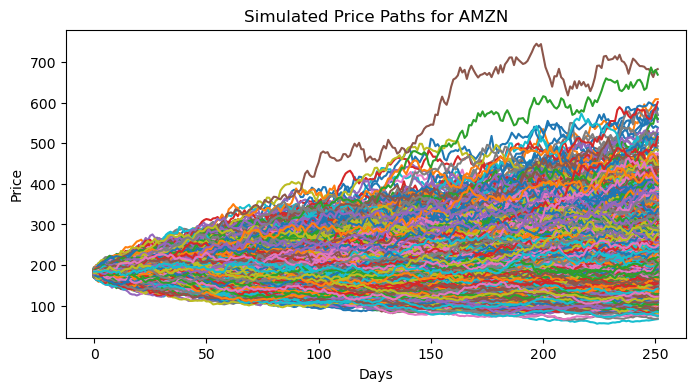

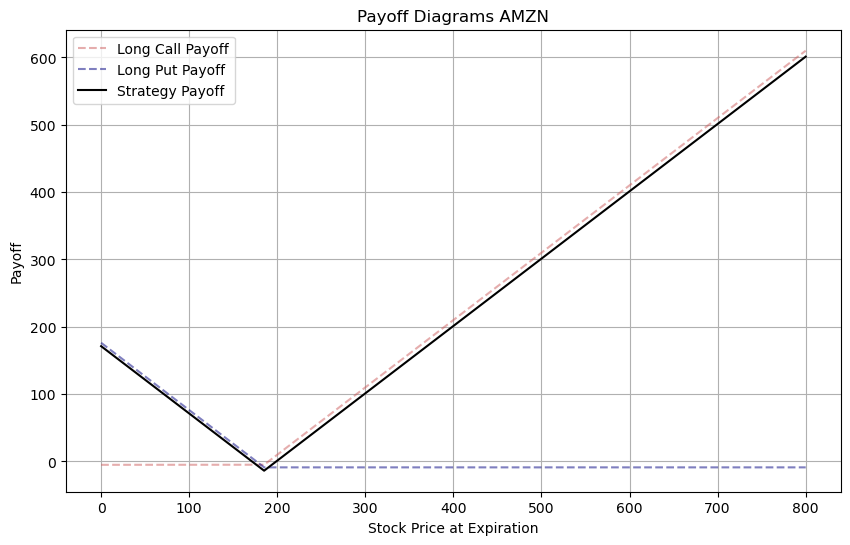

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-0.22
El rendimiento esperado de la estrategia es de -1.61%
La probabilidad de ganancia es de 42.02%
El intervalo de confianza del 95% para el profit es de [-13.260851444655955, 24.049878656645227]



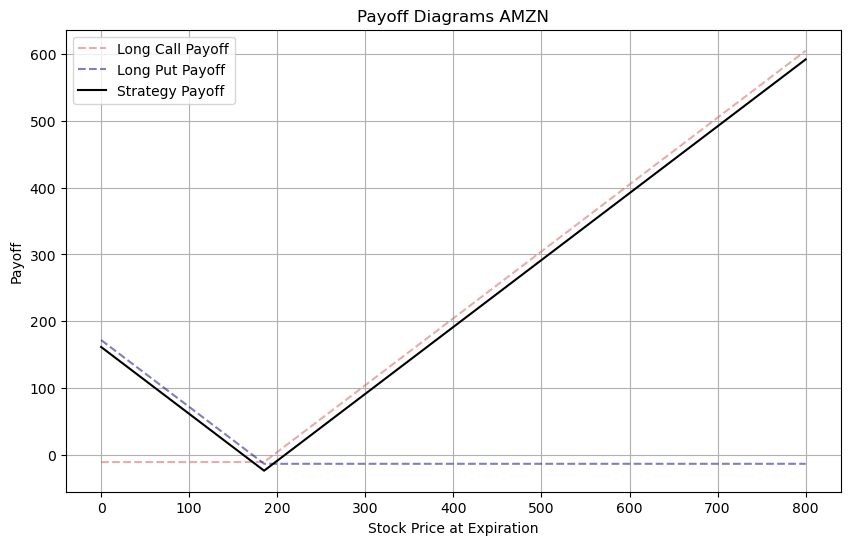

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $0.91
El rendimiento esperado de la estrategia es de 3.89%
La probabilidad de ganancia es de 43.32%
El intervalo de confianza del 95% para el profit es de [-22.33851817556696, 48.498622232374515]



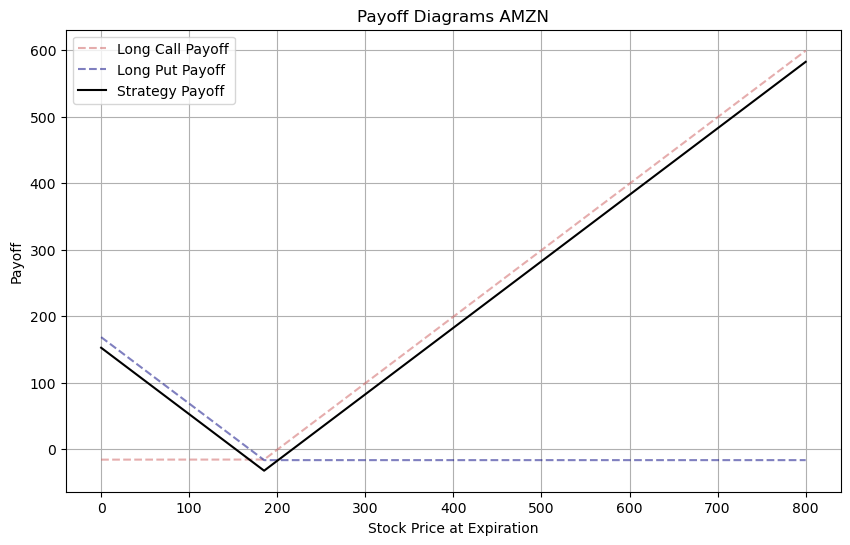

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $3.82
El rendimiento esperado de la estrategia es de 11.72%
La probabilidad de ganancia es de 44.78%
El intervalo de confianza del 95% para el profit es de [-31.274720850688794, 85.02010953525806]



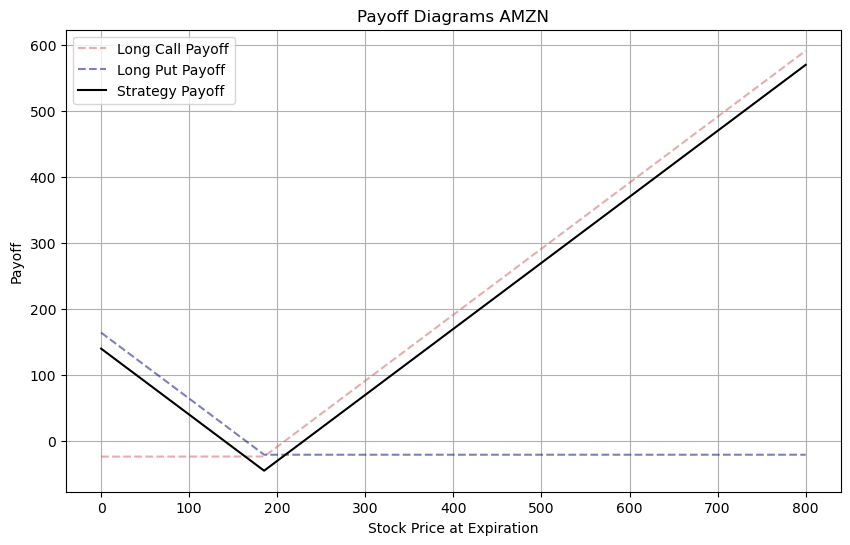

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $12.92
El rendimiento esperado de la estrategia es de 28.31%
La probabilidad de ganancia es de 47.95%
El intervalo de confianza del 95% para el profit es de [-43.6731696748897, 160.60361589174886]



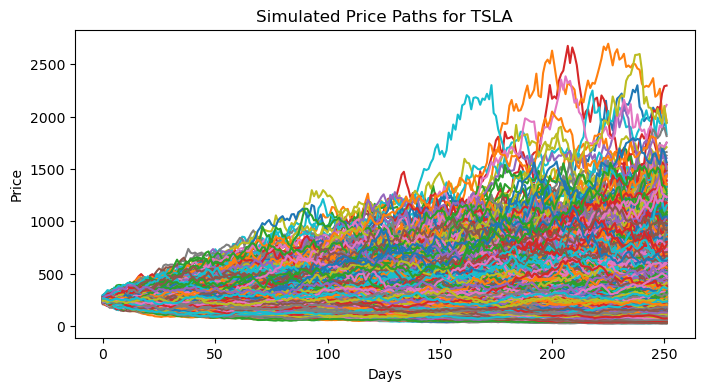

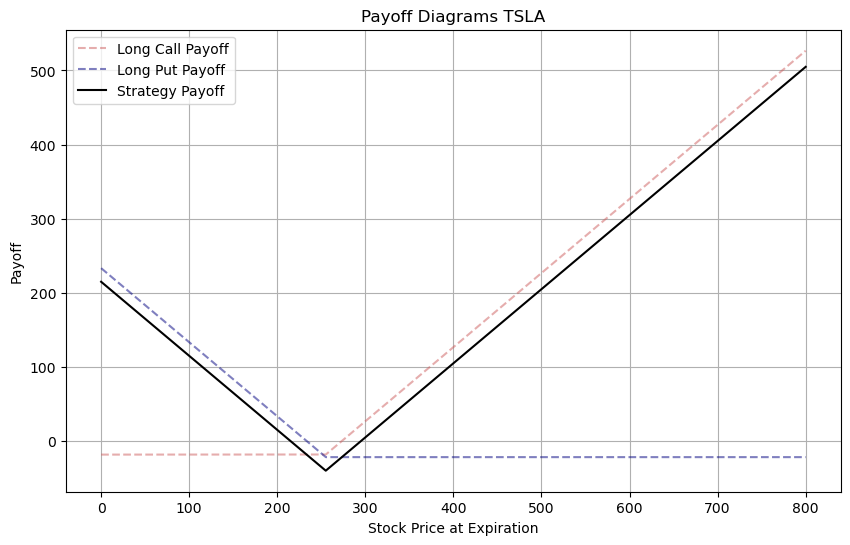

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.22
El rendimiento esperado de la estrategia es de 0.55%
La probabilidad de ganancia es de 42.37%
El intervalo de confianza del 95% para el profit es de [-38.50445039433376, 76.50309530354012]



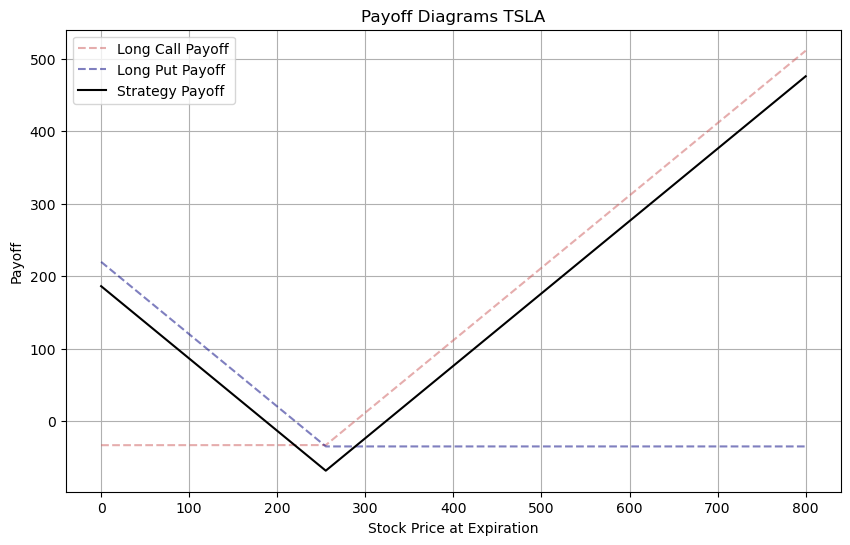

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $2.92
El rendimiento esperado de la estrategia es de 4.23%
La probabilidad de ganancia es de 42.47%
El intervalo de confianza del 95% para el profit es de [-66.17339608368317, 165.94168526786595]



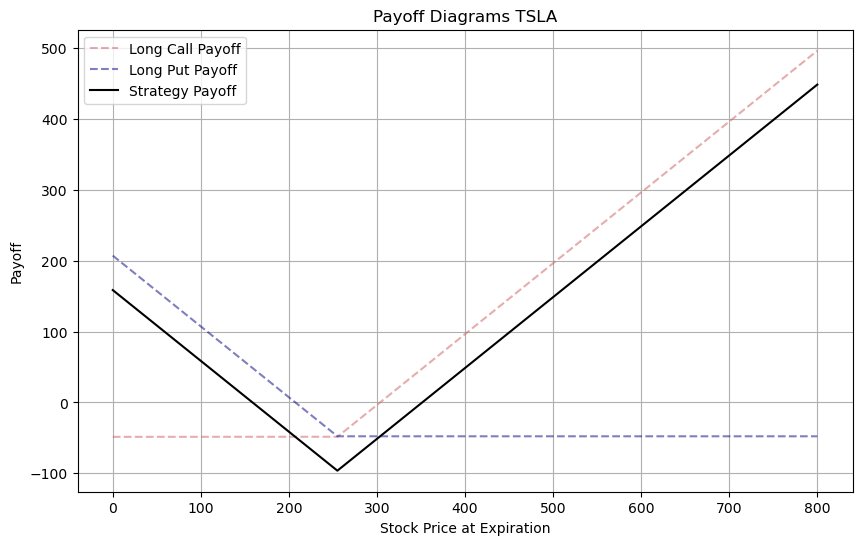

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $9.29
El rendimiento esperado de la estrategia es de 9.63%
La probabilidad de ganancia es de 41.78%
El intervalo de confianza del 95% para el profit es de [-92.55008414245972, 298.466783633759]



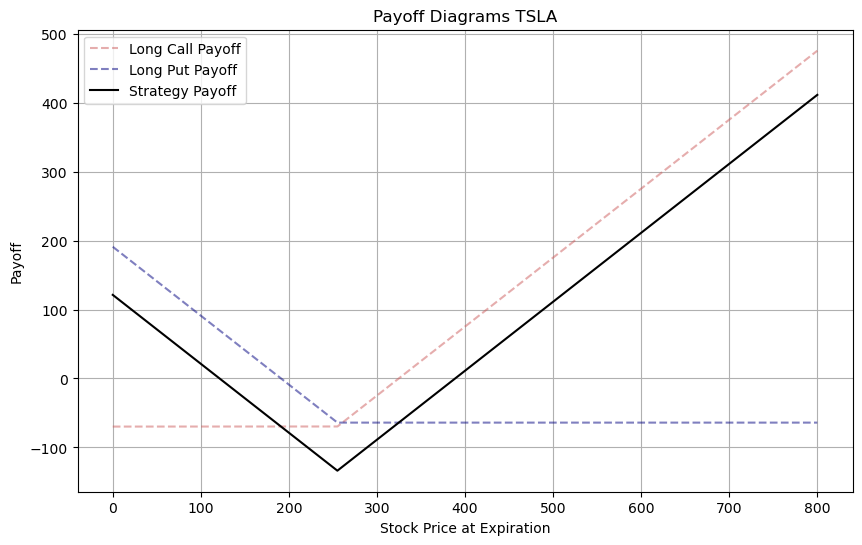

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $28.84
El rendimiento esperado de la estrategia es de 21.55%
La probabilidad de ganancia es de 40.94%
El intervalo de confianza del 95% para el profit es de [-128.42476402844056, 579.9423471235093]



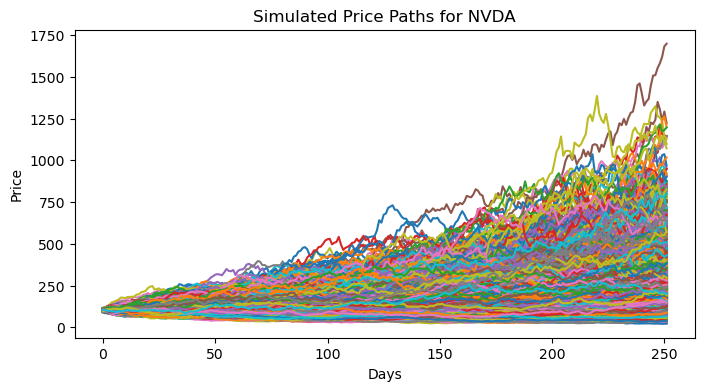

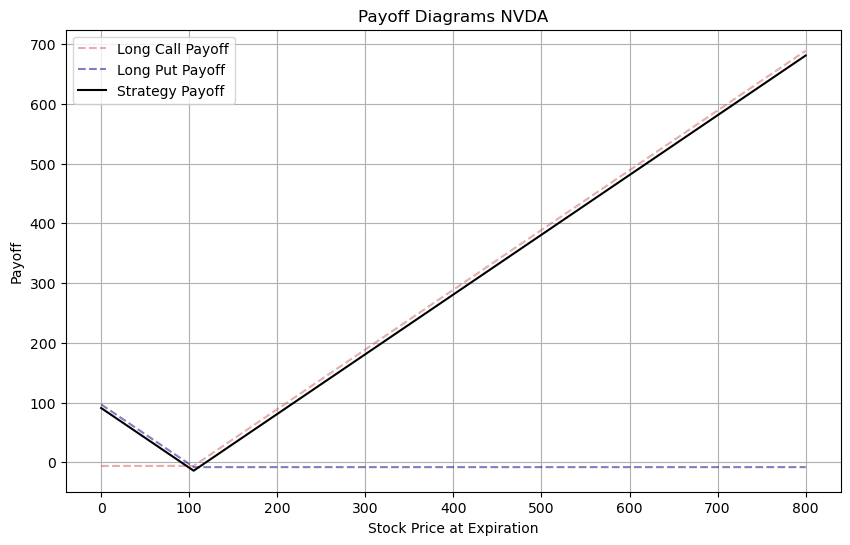

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.81
El rendimiento esperado de la estrategia es de 5.74%
La probabilidad de ganancia es de 43.59%
El intervalo de confianza del 95% para el profit es de [-13.478228497427063, 31.032924766649547]



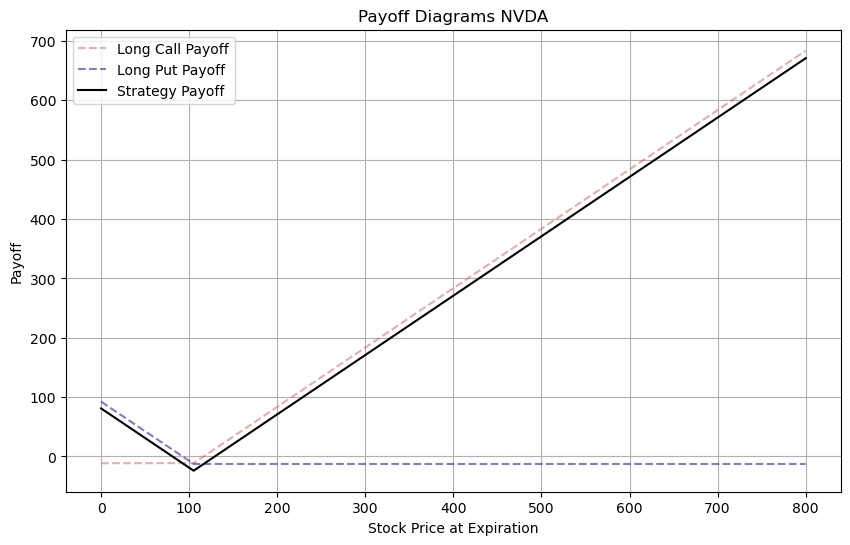

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $6.84
El rendimiento esperado de la estrategia es de 28.41%
La probabilidad de ganancia es de 48.64%
El intervalo de confianza del 95% para el profit es de [-22.98177602464938, 81.51255242450807]



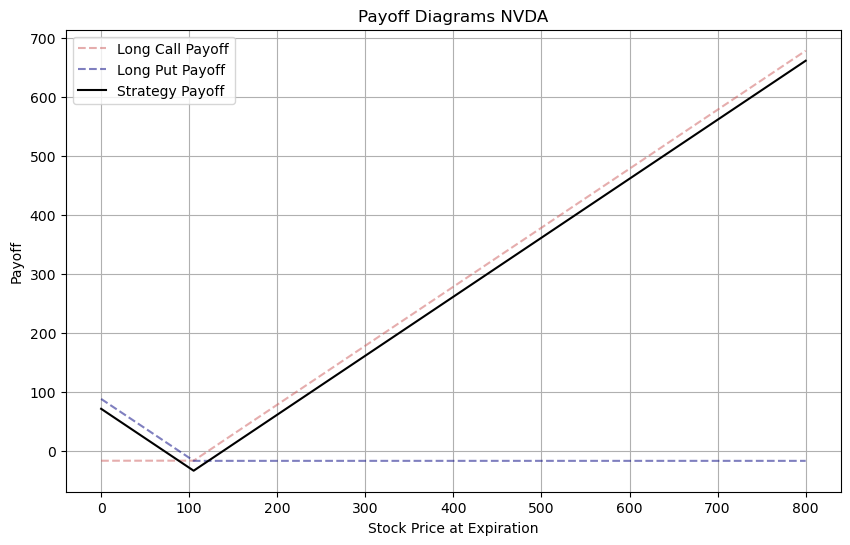

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $22.12
El rendimiento esperado de la estrategia es de 65.61%
La probabilidad de ganancia es de 54.96%
El intervalo de confianza del 95% para el profit es de [-32.06252585025763, 168.33480928544728]



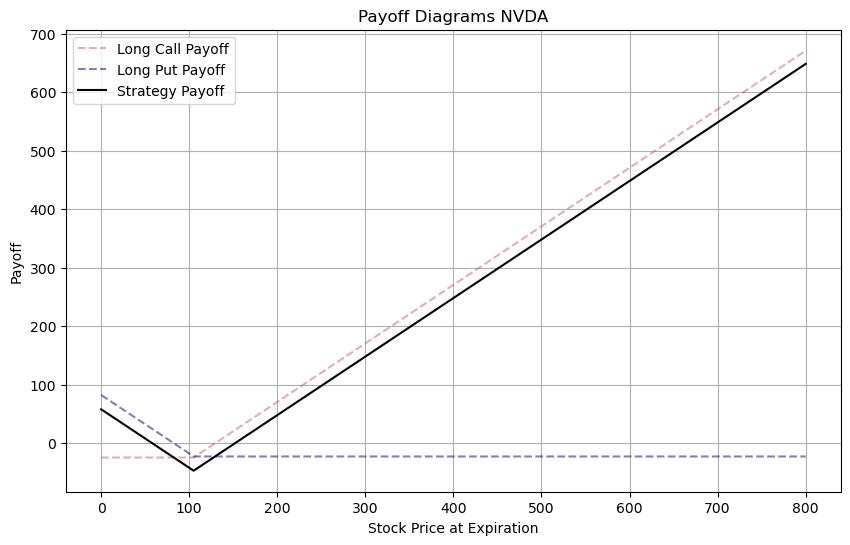

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $75.01
El rendimiento esperado de la estrategia es de 159.99%
La probabilidad de ganancia es de 65.53%
El intervalo de confianza del 95% para el profit es de [-43.883339799794136, 425.08984649398064]



In [7]:
straddle = MultiStraddle(tickers, start_date, end_date, strikes)
straddle.execute()